In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import seaborn as sn
import pandas as pd

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Dropout Regularization and Batch Normalization

/content/drive/MyDrive/Course Material/Supervised Machine Learning/Dropout Regularization and Batch Normalization


# Importing the data

In [6]:
df2 = pd.read_csv('WESAD_Data/user2.csv', header = None)
df3 = pd.read_csv('WESAD_Data/user3.csv', header = None)
df4 = pd.read_csv('WESAD_Data/user4.csv', header = None)
df5 = pd.read_csv('WESAD_Data/user5.csv', header = None)
df6 = pd.read_csv('WESAD_Data/user6.csv', header = None)
df7 = pd.read_csv('WESAD_Data/user7.csv', header = None)
df8 = pd.read_csv('WESAD_Data/user8.csv', header = None)
df9 = pd.read_csv('WESAD_Data/user9.csv', header = None)
df10 = pd.read_csv('WESAD_Data/user10.csv', header = None)
df11 = pd.read_csv('WESAD_Data/user11.csv', header = None)
df13 = pd.read_csv('WESAD_Data/user13.csv', header = None)
df14 = pd.read_csv('WESAD_Data/user14.csv', header = None)
df15 = pd.read_csv('WESAD_Data/user15.csv', header = None)
df16 = pd.read_csv('WESAD_Data/user16.csv', header = None)
df17 = pd.read_csv('WESAD_Data/user17.csv', header = None)

In [9]:
df17.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.064796,-0.065485,-0.064796,-0.063419,-0.068927,-0.088202,-0.089235,-0.085621,-0.076155,-0.072713,...,-0.420191,-0.413479,-0.410209,-0.408488,-0.399367,-0.391794,-0.393859,-0.390762,-0.380263,0
1,-0.370453,-0.360815,-0.357029,-0.341196,-0.333451,-0.330525,-0.317445,-0.300579,-0.289392,-0.287499,...,-0.212117,-0.204889,-0.201103,-0.191121,-0.187334,-0.193530,-0.205750,-0.212634,-0.214355,0
2,-0.217281,-0.212978,-0.209020,-0.213322,-0.215043,-0.214871,-0.215560,-0.221755,-0.223132,-0.232426,...,-0.005937,0.006455,0.016781,0.018502,0.023321,0.027796,0.034680,0.020395,-0.028654,0
3,-0.092677,-0.169091,-0.250841,-0.331902,-0.395236,-0.436197,-0.427076,-0.388008,-0.331902,-0.285090,...,-0.183376,-0.212290,-0.234835,-0.242064,-0.250325,-0.267535,-0.279754,-0.291285,-0.310905,0
4,-0.329320,-0.335688,-0.342228,-0.348252,-0.362709,-0.377165,-0.384910,-0.383533,-0.383533,-0.382501,...,-0.014542,-0.033129,-0.034162,-0.025901,-0.021770,-0.020393,-0.012132,-0.001462,0.007660,0


In [10]:
df2.shape

(5798, 257)

In [11]:
data = pd.concat([df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df13, df14, df15, df16, df17])

In [12]:
data.shape

(90630, 257)

In [13]:
data[256].value_counts()

1    48147
2    27244
0    15239
Name: 256, dtype: int64

In [14]:
n_classes = len(np.unique(data[256].value_counts()))
n_classes

3

# Extracting Features and Labels

In [15]:
X = data[data.columns[0:-1]].values
y = data[data.columns[-1]].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform to Tensor and Using DataLoader

In [17]:
# Convert to tensor
train_data = torch.tensor(X_train, dtype = torch.float32)
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test, dtype = torch.float32)
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize, drop_last=True)

# Observe the batches of training and test data

In [18]:
for x,y in train_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([32, 256])
torch.Size([32])


In [19]:
print(y)

tensor([1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2,
        1, 1, 1, 0, 2, 1, 2, 1])


In [20]:
for x,y in test_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([32, 256])
torch.Size([32])


# Creating the Neural Network Model Without Dropout Regularization

In [21]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(256,512)

    # hidden layer
    self.fc1 = nn.Linear(512,256)
    self.fc2 = nn.Linear(256,128)

    # output layer
    self.output = nn.Linear(128,3)

  # forward pass

  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# Create the model Instance and setting the parameters

In [22]:
model = NeuralNet()

lossfun = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),momentum = 0.9, lr=.01)


# Training and Testing the model

In [ ]:
epochs = 25

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


  # loop over epochs
for epoch in range(epochs):

    model.train()
    model.to(device)
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      ypred =  model(X)
      loss = lossfun(ypred,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      ypred = ypred.cpu()
      y = y.cpu()

      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      batchAcc.append(acc)

    trainAcc.append( np.mean(batchAcc) )

    losses[epoch] = np.mean(batchLoss)

    # TESTING


    model.eval()
    with torch.no_grad():

        for X,y in test_loader:

            X = X.to(device)
            y = y.to(device)


            ypred =  model(X)
            ypred = ypred.cpu()
            y = y.cpu()

    testAcc.append( 100*torch.mean((torch.argmax(ypred,axis=1)==y).float()) )
    if (epoch % 5) == 0:
      print(f'epoch: {epoch}   loss: {loss.item()}')




epoch: 0   loss: 0.9783344268798828
epoch: 5   loss: 0.7082510590553284
epoch: 10   loss: 0.617218017578125
epoch: 15   loss: 0.5489132404327393
epoch: 20   loss: 0.44004330039024353


# Plotting and Visualization

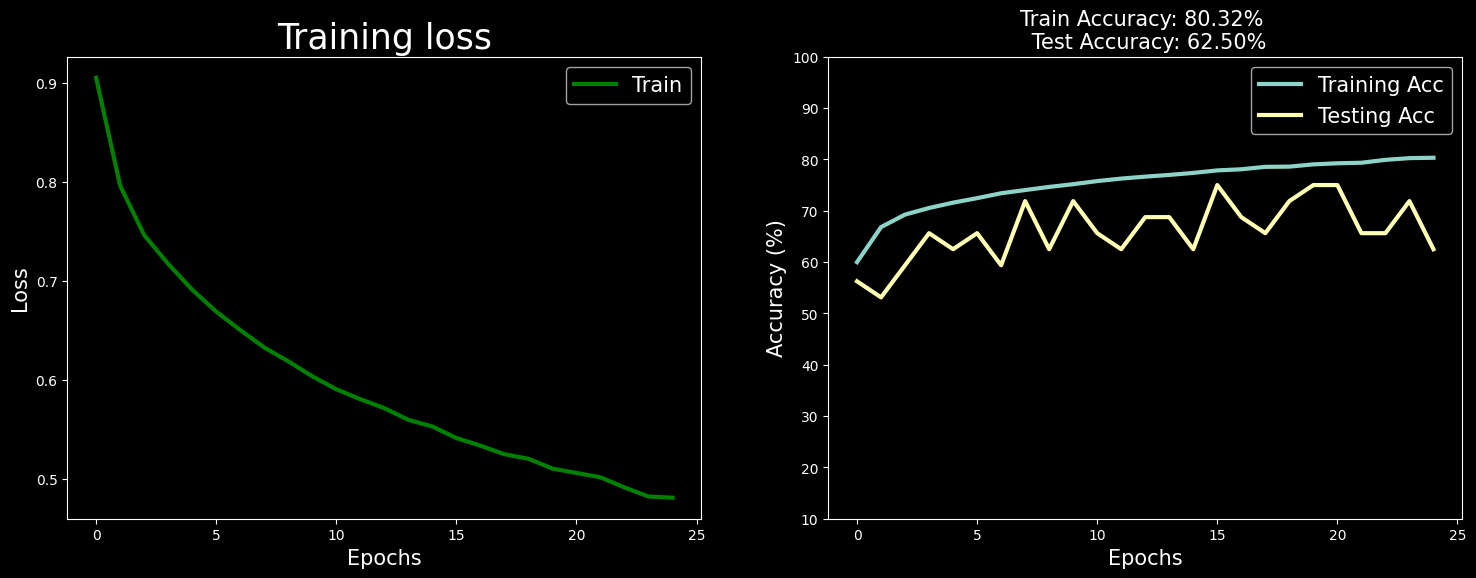

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

# Neural Network With Dropout Regularization

In [23]:
class NeuralNet2(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(256,512)

    # hidden layer
    self.fc1 = nn.Linear(512,256)
    self.dropout = nn.Dropout(0.1)
    self.fc2 = nn.Linear(256,128)
    self.dropout = nn.Dropout(0.1)

    # output layer
    self.output = nn.Linear(128,3)

  # forward pass

  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = self.dropout(x)
    x = F.relu( self.fc2(x) )
    x = self.dropout(x)
    return self.output(x)

# Create model instance and setting parameters

In [ ]:
model2 = NeuralNet2()

lossfun = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model2.parameters(),momentum = 0.9, lr=.01)

In [ ]:
epochs = 25
losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


  # loop over epochs
for epoch in range(epochs):

    model2.train()
    model2.to(device)
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      ypred =  model2(X)
      loss = lossfun(ypred,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      ypred = ypred.cpu()
      y = y.cpu()

      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      batchAcc.append(acc)

    trainAcc.append( np.mean(batchAcc) )

    losses[epoch] = np.mean(batchLoss)

    # TESTING


    model2.eval()
    with torch.no_grad():

        for X,y in test_loader:

            X = X.to(device)
            y = y.to(device)


            ypred =  model2(X)
            ypred = ypred.cpu()
            y = y.cpu()

    testAcc.append( 100*torch.mean((torch.argmax(ypred,axis=1)==y).float()) )
    if (epoch % 5) == 0:
      print(f'epoch: {epoch}   loss: {loss.item()}')


epoch: 0   loss: 0.8598504662513733
epoch: 5   loss: 0.8022669553756714
epoch: 10   loss: 0.7706445455551147
epoch: 15   loss: 0.49501195549964905
epoch: 20   loss: 0.3993106782436371


# Plotting and Visualization

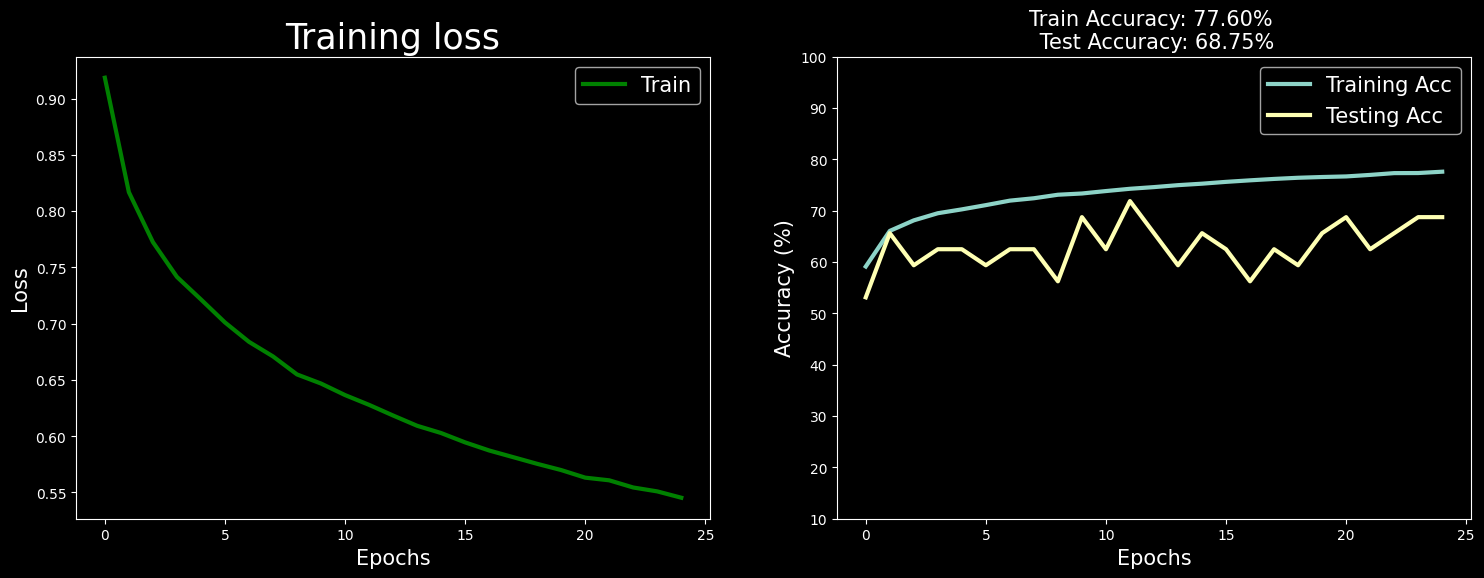

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()